# Y.Afisha's Optimized Marketing Expenses

Pendahuluan
 - Tahap 1. Pra-pemrosesan Data
 - Tahap 2. Analisis Data
   - Data Produk
        - Metrik Sesi
        - Durasi Per Sesi
   - Data Sales
        - Pembelian Pertama
        - Membuat Cohort
   - Data Marketing
        - Menghitung CAC
        - Laba Kotor
        - Menghitung ROI
 - Tahap 3. Kesimpulan

# Pendahuluan
Sebagai pegawai intern pada perusahaan Y.Afisha, saya diminta untuk menganalisa data berikut untuk dapat mengoptimalkan biaya marketing yang dikeluarkan perusahaan. Langkah pertama yang dilakukan adalah pra-pemrosesan data untuk menyiapkan data agar siap dianalisis. Saya akan menghitung sesi pengguna pada periode waktu tertentu dan membuat cohortnya. Selanjutnya saya akan menghitung cac, ltv dan membuat kesimpulan untuk hasil analisis data ini.

## Tahap 1 Pra-pemrosesan Data

In [1]:
#memuat library yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Dataset Visits
Kita akan memuat dataset visits, dataset ini berisi kolom-kolom berikut :
- *Device* — (perangkat pengguna)
- *End Ts* — ( tanggal dan waktu berakhirnya sesi kunjungan)
- *Source Id* — (penanda sumber iklan yang mendatangkan pengguna)
- *Start Ts* — (tanggal dan waktu dimulainya sesi kunjungan)
- *Uid* — (user id unik atau id unik pengguna)

In [2]:
visits = pd.read_csv('/datasets/visits_log_us.csv')

In [3]:
# menampilkan size data dan informasi umum
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 79.3 MB


Tipe data pada kolom end ts dan start ts adalah object, ini perlu dirubah menjadi tipe data datetime karena nilai kedua kolom ini berisi tanggal dan jam. Dan kolom device memiliki tipe data object, kita akan mengganti tipe datanya menjadi category, tipe data ini mirip dengan object tetapi menggunakan lebih sedikit memori.

In [4]:
# mengoptimalkan data size
visits = pd.read_csv('/datasets/visits_log_us.csv',
                    dtype={'Device' : 'category'},
                     parse_dates=['End Ts', 'Start Ts'])

In [5]:
# menampilkan size data terbaru
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


Setelah merubah tipe data pada beberapa kolom, kini memory usage datasets visits yang semula 79.3 MB menjadi 11.3 MB saja.
Dengan mengoptimalkan size data, kita dapat menghindari error atau proses running kode yang memakan waktu lama.

In [6]:
# mengecek missing value pada dataset visits
visits.isna().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [7]:
# mengecek niai duplikat pada datasets visits
visits.duplicated().sum()

0

In [8]:
# mengganti seluruh nama kolom menjadi huruf kecil agar mudah dibaca
visits = visits.rename(columns=str.lower)

In [9]:
# memperbaiki penulisan nama kolom
visits = visits.rename(columns={'end ts': 'end_ts',
                               'source id': 'source_id',
                               'start ts': 'start_ts'})

In [10]:
visits.describe()

,source_id,uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


In [11]:
# menampilkan dataset 
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Tidak ditemukan missing values dan nilai duplikat pada dataset ini, tipe datanya juga sudah sesuai. Mari kita lanjutkan pra-pemrosesan datasets berikutnya.

#### Datasets Orders
Kita akan memuat datasets orders yang berisi kolom-kolom berikut :
- *Uid* — (id unik pengguna saat melakukan order)
- *Buy Ts* — (tanggal dan waktu order)
- *Revenue* — (jumlah seluruh pendapatan Y.Afisha)

In [12]:
orders = pd.read_csv('/datasets/orders_log_us.csv')

In [13]:
# menampilkan size data dan informasi umum
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.4 MB


Walaupun size data ini termasuk kecil, kita perlu membiasakan untuk mengoptimalkan size data dengan merubah tipe data sesuai yang dibutuhkan. Untuk dataset orders, tipe data yang perlu dirubah hanya tipe data kolom buy ts yang nilainya berupa tanggal dan waktu.

In [14]:
# mengoptimalkan size data
orders = pd.read_csv('/datasets/orders_log_us.csv',
                     parse_dates=['Buy Ts'])

In [15]:
# menampilkan size data terbaru
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Setelah dioptimalkan, size dataset orders telah berubah dari 4.4 MB menjadi 1.2 MB

In [16]:
# mengecek missing value pada dataset orders
orders.isna().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [17]:
# mengecek nilai dupikat pada dataset orders
orders.duplicated().sum()

0

In [18]:
# mengganti seluruh nama kolom menjadi huruf kecil agar mudah dibaca
orders = orders.rename(columns=str.lower)

In [19]:
# memperbaiki penulisan nama kolom
orders = orders.rename(columns={'buy ts': 'buy_ts'})

In [20]:
orders.describe()

,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [21]:
# menampilkan dataset
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Dataset orders juga tidak memiliki missing value dan nilai duplikat, tipe data juga sudah dirubah dan dioptimalkan. Kita akan melanjutkan pra-pemrosesan dataset yang terakhir yaitu dataset costs.

#### Dataset Costs
Dataset costs memiliki kolom-kolom sebagai berikut :
- source_*id* — (sumber iklan)
- *dt* — (tanggal)
- *costs* — (expenses on this ad source on this day)

In [22]:
# memuat dataset
costs = pd.read_csv('/datasets/costs_us.csv')

In [23]:
# menampilkan size data dan informasi umum
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.2 KB


Sama seperti dataset orders, dataset costs juga memiliki size data yang kecil, namun kita tetap perlu merubah tipe data pada kolom yang dibutuhkan. Kolom dt hanya memuat tanggal, maka dari itu akan kita rubah tipe datanya menjadi integer.

In [24]:
# mengubah tipe data object menjadi integer
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

In [25]:
# menampilkan size data terbaru
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Size dataset orders yang semula 206.2 KB menyusut menjadi 59.7 KB dengan mengubah tipe data kolom dt. Perbedaan yang lumayan jauh.

In [26]:
# menampilkan dataset
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Kita sudah selesai melakukan pra-pemrosesan data pada ketiga dataset ini. Semua dataset ini telah siap untuk dianalisis lebih lanjut. Berikutnya kita akan membuat laporan dan menghitung metrik.

## Tahap 2 Analisis Data

Untuk tahap analisis data, kita akan melakukan analisis terhadap produk terlebih dulu, yaitu :
1. Berapa banyak pengguna yang menggunakan setiap hari, minggu dan bulan?
2. Berapa banyak sesi yang terjadi per harinya? ( 1 pengguna bisa saja melakukan lebih dari satu sesi)
3. Berapa lama durasi per sesi?
4. Seberapa sering pengguna kembali?

Mari kita mulai analisis data ini.
### Data Produk

In [27]:
# menggabungkan dataset visits dan orders
product = pd.merge(visits, orders, on='uid')

In [28]:
# menampilkan dataset yang sudah digabung
product

,device,end_ts,source_id,start_ts,uid,buy_ts,revenue
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:25:00,2.33
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:25:00,2.33
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-04 12:46:00,2.44
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 00:01:00,1.53
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 19:16:00,1.53
...,...,...,...,...,...,...,...
761802,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017-12-04 12:46:00,4.15
761803,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017-11-20 23:43:00,3.67
761804,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017-11-29 20:33:00,3.05
761805,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23 21:16:00,0.49


Untuk mengetahui berapa banyak pengguna per hari, minggu serta bulan, kita akan membuat kolom baru yang memuat sesi pengguna per hari, minggu, bulan dan tahun berdasarkan kolom start_ts.

In [29]:
# membuat kolom baru untuk menghitung sesi pengguna
product['session_year'] = product['start_ts'].dt.year
product['session_month'] = product['start_ts'].dt.month
product['session_week'] = product['start_ts'].dt.week
product['session_date'] = product['start_ts'].dt.date
product.head()

,device,end_ts,source_id,start_ts,uid,buy_ts,revenue,session_year,session_month,session_week,session_date
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,5,20,2018-05-20
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,3,10,2018-03-09
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-04 12:46:00,2.44,2017,9,35,2017-09-03
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 00:01:00,1.53,2017,9,35,2017-09-03
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 19:16:00,1.53,2017,9,35,2017-09-03


Jika dilihat dengan seksama, ada uid sama yang memulai pada tanggal dan jam yang sama tetapi melakukan order pada tanggal dan jam yang berbeda. Revenue yang dihasilkan pun berbeda, sehingga data ini tentunya bukan duplikat.
Selanjutnya, kita akan menghitung berapa banyak sesi yang dilakukan oleh setiap pengguna per hari, minggu serta bulan.

#### Metrik Sesi Setiap Pengguna
Kita perlu mencari tahu metrik sesi yang dilakukan setiap pengguna. Kira-kira berapa kali pengguna melakukan sesi kunjungan produk kita? Untuk itu kita lebih dulu menghitung pengguna dengan menggunakan id uniknya dan kolom-kolom sesi baru yang telah kita buat di atas.

In [30]:
sessions_per_user = product.groupby(['session_date','session_week','session_month']).agg({'uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])
sessions_per_user

,,,n_sessions,n_users,sessions_per_user
session_date,session_week,session_month,,,
2017-06-01,22,6,1739,170,10.229412
2017-06-02,22,6,1230,177,6.949153
2017-06-03,22,6,528,109,4.844037
2017-06-04,22,6,767,118,6.500000
2017-06-05,23,6,1764,267,6.606742
...,...,...,...,...,...
2018-05-27,21,5,1401,161,8.701863
2018-05-28,22,5,1799,268,6.712687
2018-05-29,22,5,2785,267,10.430712


Kita telah mendapatkan data sesi setiap pengguna, dalam 1 hari, setiap pengguna melakuan 4 hingga 10 sesi. Sepertinya para pengguna cukup sering menggunakan produk.

<AxesSubplot:title={'center':'user sessions per day'}, xlabel='session_date,session_week,session_month'>

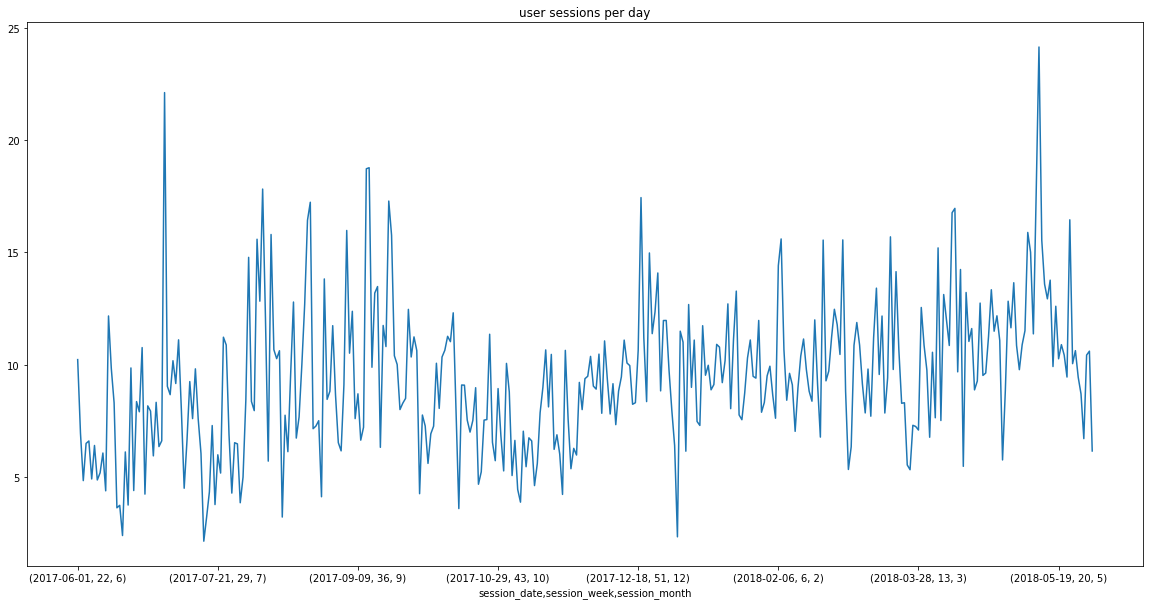

In [31]:
sessions_per_user['sessions_per_user'].plot(kind='line', figsize=(20,10),title='user sessions per day')

Dari grafik diatas, pada tahun 2017 pertengahan Juni sesi pengguna memuncak lalu turun dan naik dengan stabil hingga Oktober. Kemudian berangsur turun pada bulan November dan kembali naik perlahan pada awal tahun 2018.

#### Durasi Per Sesi
Selanjutnya kita akan menghitung lama berapa durasi yang dihabiskan pengguna selama sesi.

In [32]:
# menghitung durasi per sesi
product['session_duration_sec'] = (product['end_ts'] - product['start_ts']).dt.total_seconds()/60
product['session_duration_sec']

0         24.0
1         28.0
2          1.0
3          1.0
4          1.0
          ... 
761802     8.0
761803    11.0
761804    21.0
761805     8.0
761806    18.0
Name: session_duration_sec, Length: 761807, dtype: float64

<AxesSubplot:title={'center':'session per user by month'}, xlabel='session_year,session_month'>

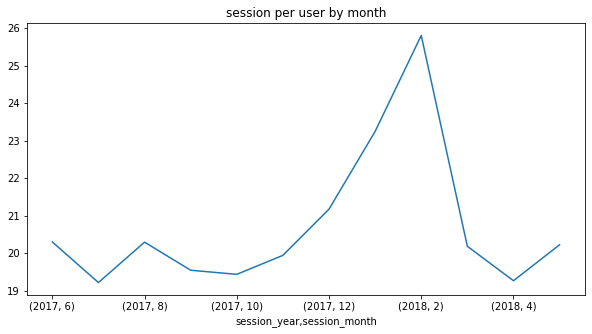

In [33]:
# menampilkan visualisasi durasi per sesi berdasarkan session month
product.groupby(['session_year', 'session_month'])['session_duration_sec'].mean().plot(kind='line', 
                                                                                       title='session per user by month',
                                                                                       figsize=(10,5))

Dari grafik diatas, rata-rata sesi berdurasi sekitar 20 detik. Adapun pada bulan Desember 2017 hingga Februari 2018, durasi sesi bertambah banyak. Mungkin banyak pengguna yang ingin melakukan order.

<AxesSubplot:title={'center':'session per user by day'}, xlabel='session_year,session_date'>

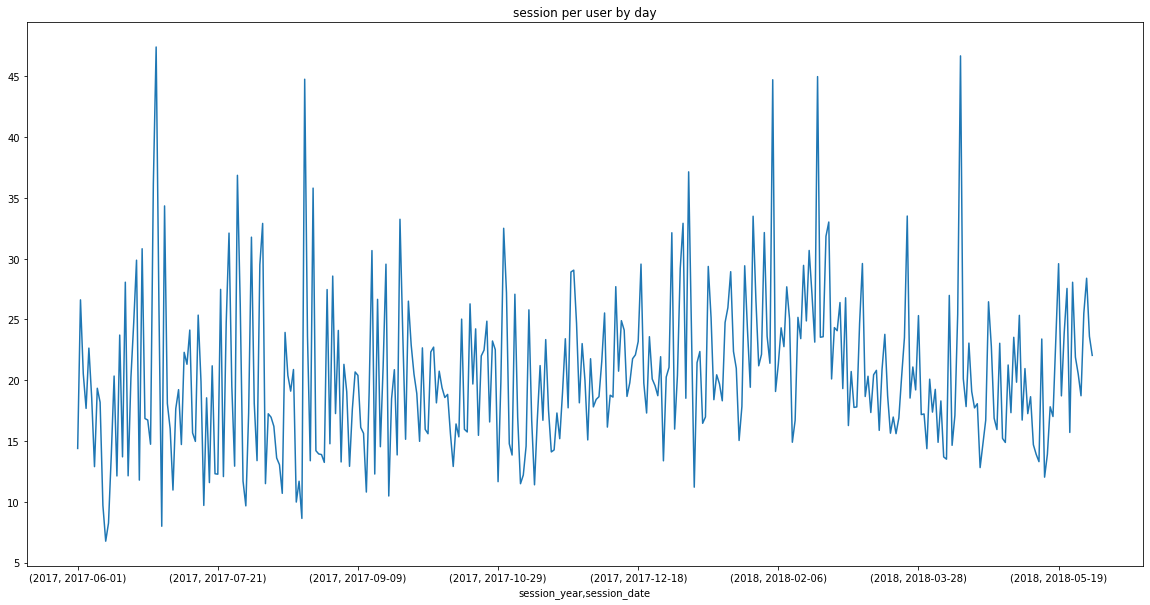

In [34]:
# menampilkan visualisasi durasi per sesi berdasarkan session date
product.groupby(['session_year', 'session_date'])['session_duration_sec'].mean().plot(kind='line', 
                                                                                       title='session per user by day',
                                                                                       figsize=(20,10))

Sesi setiap pengguna per harinya terlihat stabil dari waktu ke waktu.

#### Menghitung Seberapa Sering Pengguna Kembali

In [35]:
product

,device,end_ts,source_id,start_ts,uid,buy_ts,revenue,session_year,session_month,session_week,session_date,session_duration_sec
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,5,20,2018-05-20,24.0
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:25:00,2.33,2018,3,10,2018-03-09,28.0
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-04 12:46:00,2.44,2017,9,35,2017-09-03,1.0
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 00:01:00,1.53,2017,9,35,2017-09-03,1.0
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-10-28 19:16:00,1.53,2017,9,35,2017-09-03,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
761802,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017-12-04 12:46:00,4.15,2017,12,49,2017-12-04,8.0
761803,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017-11-20 23:43:00,3.67,2017,11,47,2017-11-20,11.0
761804,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017-11-29 20:33:00,3.05,2017,11,48,2017-11-29,21.0
761805,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23 21:16:00,0.49,2018,4,17,2018-04-23,8.0


In [36]:
# menghitung dau,wau dan mau total
dau_total = product.groupby('session_date').agg({'uid':'nunique'}).mean()
wau_total = product.groupby('session_week').agg({'uid':'nunique'}).mean()
mau_total = product.groupby('session_month').agg({'uid':'nunique'}).mean()

print(int(dau_total))
print(int(wau_total))
print(int(mau_total))

225
1299
4686


In [37]:
sticky_wau =  dau_total / wau_total * 100
print(sticky_wau)
sticky_mau = dau_total / mau_total * 100
print(sticky_mau)

uid    17.353072
dtype: float64
uid    4.809767
dtype: float64


Dari hasil perhitungan diatas, rasio pengguna yang kembali menggunakan produk per minggunya ada sekitar 17% dan 4% untuk pengguna yang kembali menggunakan produk setelah sebulan. Jumlah yang cukup bagus sepertinya.

**Kesimpulan Data Produk:**
1. Dari grafik diatas yang sudah dibuat, pada tahun 2017 pertengahan Juni sesi pengguna memuncak lalu turun dan naik dengan stabil hingga Oktober. Kemudian berangsur turun pada bulan November dan kembali naik perlahan pada awal tahun 2018.
2. Rata-rata sesi berdurasi sekitar 20 detik. Adapun pada bulan Desember 2017 hingga Februari 2018, durasi sesi bertambah banyak. Mungkin banyak pengguna yang ingin melakukan order.
3. Rata-rata pengguna yang aktif menggunakan produk berjumlah 225 orang, untuk per minggu ada 1299 pengguna aktif dan per bulannya ada 4686 pengguna. Jumlahnya cukup stabil.
3. Dari grafik diatas, rata-rata sesi berdurasi sekitar belasan detik. Pada bulan November hingga Desember, sesi pengguna per hari menurun cukup banyak dibanding bulan-bulan sebelumnya.
4. Dalam sebulan, rasio pengguna yang kembali adalah sekitar 4%

### Data Sales
Selanjutnya kita akan menganalisis data untuk penjualan untuk mengetahui hal-hal berikut :
1. Kapan pengguna mulai melakukan pembelian atau melakukan order?
2. Berapa banyak order yang dilakukan pengguna dalam periode waktu tertentu?
3. Berapa banyak pendapatan yang dihasilkan (LTV)?

#### Kapan Pengguna Mulai Membeli
Kita akan mengkategorikan kapan pembelian pertama dilakukan berdasarkan tanggal dan bulan.
Pertama, kita cari tahu kapan pengguna pertama kali melakukan kunjungan.
##### Tanggal Kunjungan Pertama

In [38]:
# mencari kapan tanggal pembelian pertama
first_visit = product.groupby('uid')[['start_ts','buy_ts']].min().reset_index()
first_visit

,uid,start_ts,buy_ts
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00


Kita telah berhasil membuat data tanggal pertama kali pengguna melakukan kunjungan, selanjutnya kita akan membuat data pembelian berdasarkan tanggal kunjungan pertama.
##### Tanggal Pembelian Pertama

In [39]:
# hitung durasi dari pertama visit sampai pertama buy
first_visit['first_order_ts'] = (first_visit['buy_ts'] - first_visit['start_ts']).dt.days
first_visit

,uid,start_ts,buy_ts,first_order_ts
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0
...,...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00,95
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00,0
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00,231
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00,103


In [40]:
first_visit['first_order_ts'].describe()

count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: first_order_ts, dtype: float64

<AxesSubplot:>

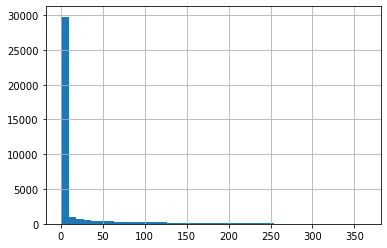

In [41]:
# tampilkan distribusi durasi harinya
first_visit['first_order_ts'].hist(bins=40)

Angka 0 menunjukkan banyak pengguna yang melakukan order setelah melakukan kunjungan. Walaupun banyak juga diantaranya yang tidak langsung melakukan order, misalnya dari sebulan hingga 3 bulan setelah sesi kunjungan dilakukan. Dari rata-rata, pengguna biasanya melakukan order sekitar 16 hari setelah melakukan kunjungan.

##### Bulan Pembelian Pertama

In [42]:
# mencari kapan bulan pembelian pertama
first_order_month = product.groupby('uid')['buy_ts'].min().reset_index()
first_order_month.columns = ['uid','first_order_month']
first_order_month

,uid,first_order_month
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


In [43]:
# mengubah tipe data kolom first order month agar menampilkan bulan dan tahun saja
first_order_month['first_order_month'] = pd.to_datetime(first_order_month['first_order_month']).dt.date

In [44]:
first_order_month['order_month'] = first_order_month['first_order_month'].astype('datetime64[M]')

In [45]:
first = first_visit.merge(first_order_month, on='uid')

#### Membuat Cohort
Kita akan membuat cohort berdasarkan bulan pembelian pertama

In [46]:
# membuat 'cohort' user, yaitu bulan pertama user tersebut melakukan pembelian
cohort = orders.groupby('uid')['buy_ts'].min().reset_index().rename(columns={'buy_ts': 'first_buy_ts'})
cohort

,uid,first_buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


In [47]:
# menggabungkan dengan semua order user
cohort = orders.merge(cohort, on="uid")

# ubah masing-masing waktu pembelian menjadi bulan
cohort['first_buy_month'] = cohort['first_buy_ts'].astype('datetime64[M]')
cohort['buy_month'] = cohort['buy_ts'].astype('datetime64[M]')

# menghitung jarak dalam bulan, sejak pertama buy sampai ke semua buy berikutnya
cohort['age_month'] = ((cohort['buy_month'] - cohort['first_buy_month']) / np.timedelta64(1, 'M')).astype(int)

In [48]:
# pivot berdasarkan 'cohort' dan perhitungan jarak bulan 'age_month'
cohort_pivot = cohort.pivot_table(
    index='first_buy_month',
    columns='age_month',
    values='uid',  # untuk menghitung jumlah user yang membeli tiap bulan
    aggfunc='nunique' # bisa kamu sesuaikan dengan pertanyaannya
)
retention = cohort_pivot[range(1,11)].div(cohort_pivot[0], axis='index')

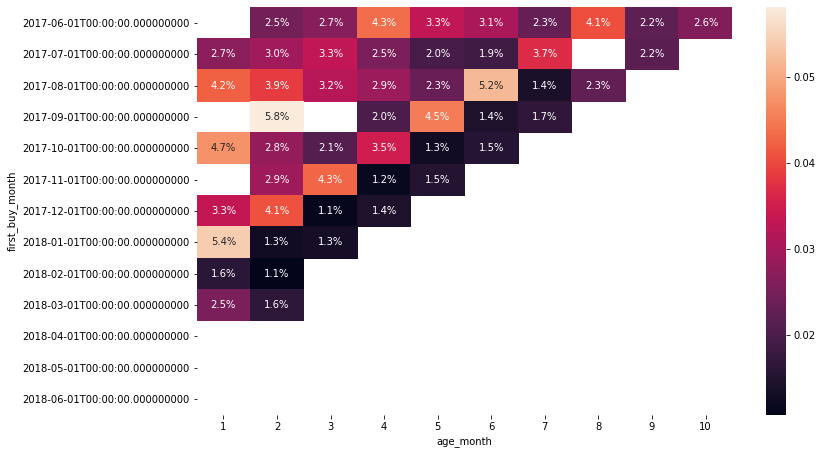

In [49]:
# menampilkan pivot table dalam bentuk heatmap
plt.figure(figsize=(12, 7.5))
sns.heatmap(retention, fmt='.1%', annot=True)
plt.show()

#### Jumlah Order Per Pengguna

In [50]:
# menghitung jumlah order pengguna
order_count = product.groupby('uid').agg({'buy_ts':'count', 'revenue':'sum'})
order_count.columns = ['order_count', 'order_revenue']
order_count

,order_count,order_revenue
uid,,
313578113262317,3,1.65
1575281904278712,4,6.10
2429014661409475,1,73.33
2464366381792757,2,4.88
2551852515556206,4,21.98
...,...,...
18445147675727495770,1,3.05
18445407535914413204,9,2.64
18445601152732270159,3,12.66


Dari hasil perhitungan diatas, kita dapat melihat jumlah pembelian setiap pengguna. Selanjutnya kita menggabungkan dataset cohort dan product untuk mencari tahu berapa jumlah pembelian per bulan.

In [51]:
cohort_buy = cohort.pivot_table(index='first_buy_month',
    columns='age_month',
    values='buy_ts',
    aggfunc='count')

order_count_per_month = cohort_buy / cohort_pivot

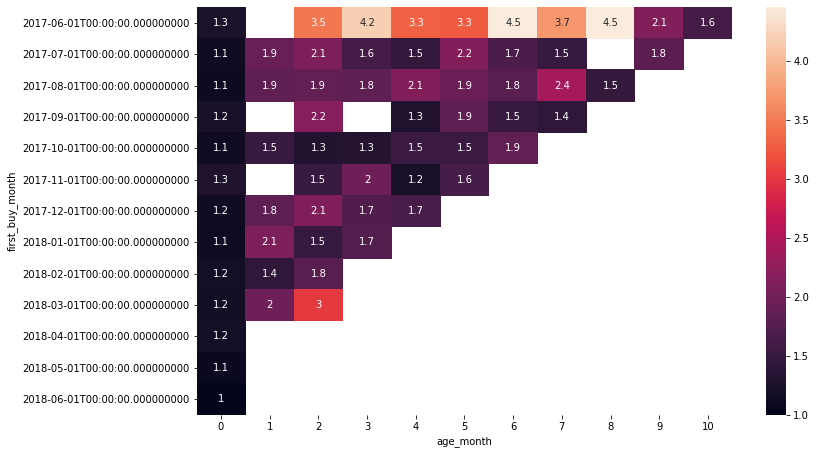

In [52]:
# menampilkan pivot table dalam bentuk heatmap
plt.figure(figsize=(12, 7.5))
sns.heatmap(order_count_per_month, annot=True)
plt.show()

#### Jumlah Order Per Bulan

In [53]:
# menggabungkan dataset
d = cohort.merge(product)
df = d.merge(first)
df

,buy_ts,revenue,uid,first_buy_ts,first_buy_month,buy_month,age_month,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,session_duration_sec,first_order_ts,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017,6,22,2017-06-01,2.0,0,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,11.0,0,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017,6,22,2017-06-01,9.0,0,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,19.0,0,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017,6,22,2017-06-01,28.0,0,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36518,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,touch,2018-05-31 09:12:00,4,2018-05-31 09:11:00,2018,5,22,2018-05-31,1.0,0,2018-05-31,2018-05-01
36519,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,desktop,2018-05-31 23:55:00,10,2018-05-31 23:05:00,2018,5,22,2018-05-31,50.0,0,2018-05-31,2018-05-01
36520,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0,desktop,2018-05-31 23:55:00,3,2018-05-31 23:52:00,2018,5,22,2018-05-31,3.0,0,2018-05-31,2018-05-01
36521,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0,desktop,2017-10-23 12:36:00,3,2017-10-23 12:32:00,2017,10,43,2017-10-23,4.0,220,2018-05-31,2018-05-01


In [54]:
# menghitung jumlah order per bulan
revenue_per_month = df.groupby(['buy_month','source_id']).agg({'buy_ts':'count', 'revenue':'sum'}).reset_index()
revenue_per_month.columns = ['buy_month','source_id','buy_ts','revenue_per_month']
revenue_per_month

,buy_month,source_id,buy_ts,revenue_per_month
0,2017-06-01,1,190,886.59
1,2017-06-01,2,235,772.28
2,2017-06-01,3,638,2576.66
3,2017-06-01,4,413,1741.17
4,2017-06-01,5,384,1666.58
...,...,...,...,...
81,2018-05-01,4,804,3605.04
82,2018-05-01,5,497,1996.94
83,2018-05-01,9,60,212.67
84,2018-05-01,10,130,426.17


Jumlah pendapatan yang dihasilkan per bulan terlihat cukup bagus. Dan nominal terendah yaitu pada bulan Juni 2016 sebesar 3.42 saja

<AxesSubplot:title={'center':'revenue_per_month'}, xlabel='buy_month'>

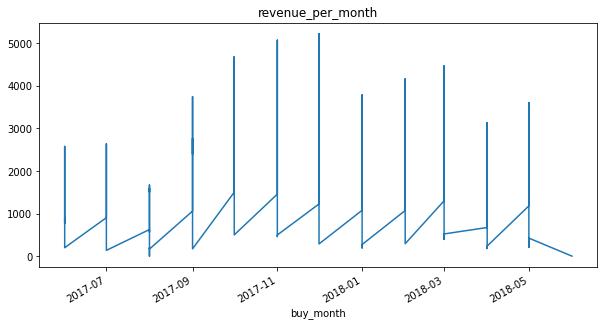

In [55]:
revenue_per_month.set_index('buy_month')['revenue_per_month'].plot(kind='line',figsize=(10,5), title='revenue_per_month')

#### Rata-rata Pembelian

In [56]:
# menghitung rata-rata pembelian
print('Average purchase size:', df['revenue'].mean().round(2))

Average purchase size: 4.14


In [57]:
# menghitung jumlah pembeli per bulan
cohort_sizes = df.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns=['first_order_month', 'n_buyers']
cohort_sizes['first_order_month'] = cohort_sizes['first_order_month'].astype('datetime64[M]')

In [58]:
gross_profit = df.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
gross_profit

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,364.43
1,2017-06-02,2017-06-01,289.42
2,2017-06-03,2017-06-01,143.15
3,2017-06-04,2017-06-01,123.48
4,2017-06-05,2017-06-01,396.68
...,...,...,...
359,2018-05-28,2018-05-01,435.38
360,2018-05-29,2018-05-01,352.43
361,2018-05-30,2018-05-01,655.71
362,2018-05-31,2018-05-01,3613.62


In [59]:
gross_profit['first_order_month'] = gross_profit['first_order_month'].astype('datetime64[M]')

In [60]:
# menghitung jarak dalam bulan, sejak pertama buy sampai ke semua buy berikutnya
gross_profit['age_month'] = ((gross_profit['order_month']) - gross_profit['first_order_month'])/ np.timedelta64(1, 'M').astype(int)

In [61]:
report = gross_profit.merge(cohort_sizes,on='first_order_month')

In [62]:
report['ltv'] = report['revenue'] / report['n_buyers']

In [63]:
report

,first_order_month,order_month,revenue,age_month,n_buyers,ltv
0,2017-06-01,2017-06-01,364.43,0 days,86,4.237558
1,2017-06-01,2017-06-01,364.43,0 days,97,3.757010
2,2017-06-01,2017-06-01,364.43,0 days,57,6.393509
3,2017-06-01,2017-06-01,364.43,0 days,55,6.626000
4,2017-06-01,2017-06-01,364.43,0 days,141,2.584610
...,...,...,...,...,...,...
10987,2018-05-01,2018-05-01,3613.62,0 days,129,28.012558
10988,2018-05-01,2018-05-01,3613.62,0 days,128,28.231406
10989,2018-05-01,2018-05-01,3613.62,0 days,146,24.750822
10990,2018-05-01,2018-05-01,3613.62,0 days,492,7.344756


In [64]:
report_pivot = cohort.pivot_table(index='first_buy_month',
                                  columns='age_month',
                                  values='revenue',
                                  aggfunc='sum')
revenue_by_first_order_month = cohort_buy / cohort_pivot

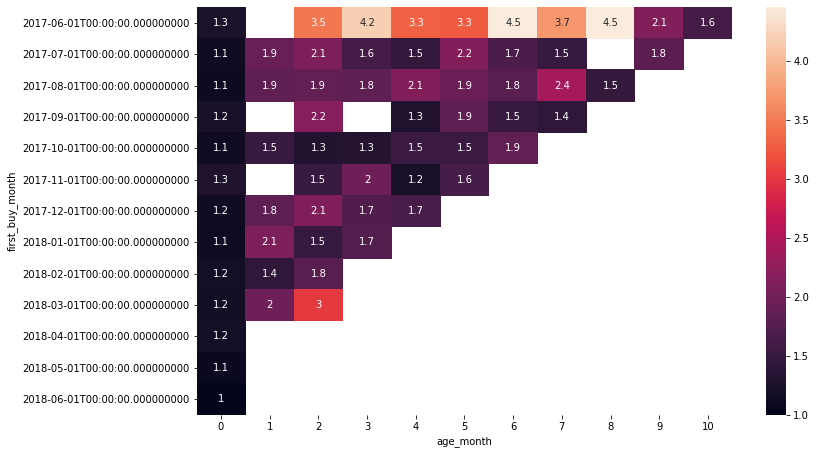

In [65]:
# menampilkan pivot table dalam bentuk heatmap
plt.figure(figsize=(12, 7.5))
sns.heatmap(revenue_by_first_order_month, annot=True)
plt.show()

**Kesimpulan Data Sales:**
1. Rata-rata pengguna biasanya melakukan order sekitar 16 hari setelah melakukan sesi kunjungan yang pertama kalinya. Banyak juga pengguna yang langsung melakukan order langsung setelah melakukan kunjungan pertama kali.
2. Jumlah revenue setiap bulannya cukup bagus, akan tetapi nominal terendah ada pada bulan Juni 2016 dengan nominal 3.42 saja

### Data Marketing
Untuk analisis kita berikutnya, kita menggunakan dataset costs untuk mencari tahu :
1. Berapa jumlah uang yang dihabiskan? Keseluruhan/per sumber/dari waktu ke waktu
2. Berapa biaya akuisisi pelanggan dari setiap sumber?
3. Seberapa menguntungkannya investasi tersebut(ROI) ?

In [66]:
# menampilkan dataset
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


Dataset costs memiliki kolom-kolom sebagai berikut :
- source_*id* — (sumber iklan)
- *dt* — (tanggal)
- *costs* — (pengeluaran untuk sumber iklan per hari ini)

#### Jumlah Pengeluaran dan CAC / Biaya Akuisisi Pelanggan

In [67]:
# menghitung keseluruhan biaya yang dikeluarkan untuk semua sumber iklan
costs['costs'].sum()

329131.62

Untuk semua sumber iklan, perusahaan mengeluarkan total biaya sebesar 330.000 ribu, kita memiliki 7 sumber iklan.
Selanjutnya kita perlu menghitung jumlah biaya yang dikeluarkan untuk setiap sumber iklan yang kita gunakan.

In [68]:
# menghitung jumlah biaya yang dikeluarkan untuk setiap sumber iklan
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Pengeluaran untuk setiap sumber iklan telah berhasil kita hitung, nominalnya tertinggi adalah untuk sumber iklan nomor 3 yaitu sekitar 142.000, sementara untuk biaya terkecil sumber iklan yang kita keluarkan adalah untuk nomor 9 dan 10. Untuk kedua sumber iklan ini masing-masing hanya sekitar 5000-6000 saja. Mungkin iklan dari kedua sumber ini tidak terlalu berpengaruh pada penjualan sehingga kita hanya mengeluarkan sedikit biaya saja. Alasan pastinya tidak diketahui karena kita tidak memiliki jumlah klik iklan.

In [69]:
# menambahkan kolom baru untuk menghitung total costs iklan per tahun dan per bulan
costs['costs_year'] = pd.to_datetime(costs['dt']).dt.to_period('Y')
costs['costs_month'] = pd.to_datetime(costs['dt']).dt.to_period('M')

# menampilkan dataset
costs

,source_id,dt,costs,costs_year,costs_month
0,1,2017-06-01,75.20,2017,2017-06
1,1,2017-06-02,62.25,2017,2017-06
2,1,2017-06-03,36.53,2017,2017-06
3,1,2017-06-04,55.00,2017,2017-06
4,1,2017-06-05,57.08,2017,2017-06
...,...,...,...,...,...
2537,10,2018-05-27,9.92,2018,2018-05
2538,10,2018-05-28,21.26,2018,2018-05
2539,10,2018-05-29,11.32,2018,2018-05
2540,10,2018-05-30,33.15,2018,2018-05


In [70]:
# menghitung total cost iklan per bulan
total_costs = costs.groupby(['costs_month','source_id']).agg({'costs':'sum'}).reset_index()
total_costs.columns = ['costs_month','source_id','total_costs_per_month']
total_costs

,costs_month,source_id,total_costs_per_month
0,2017-06,1,1125.61
1,2017-06,2,2427.38
2,2017-06,3,7731.65
3,2017-06,4,3514.80
4,2017-06,5,2616.12
...,...,...,...
79,2018-05,3,9411.42
80,2018-05,4,4214.21
81,2018-05,5,3669.56
82,2018-05,9,362.17


Text(0.5, 1.0, 'total costs per month for source id')

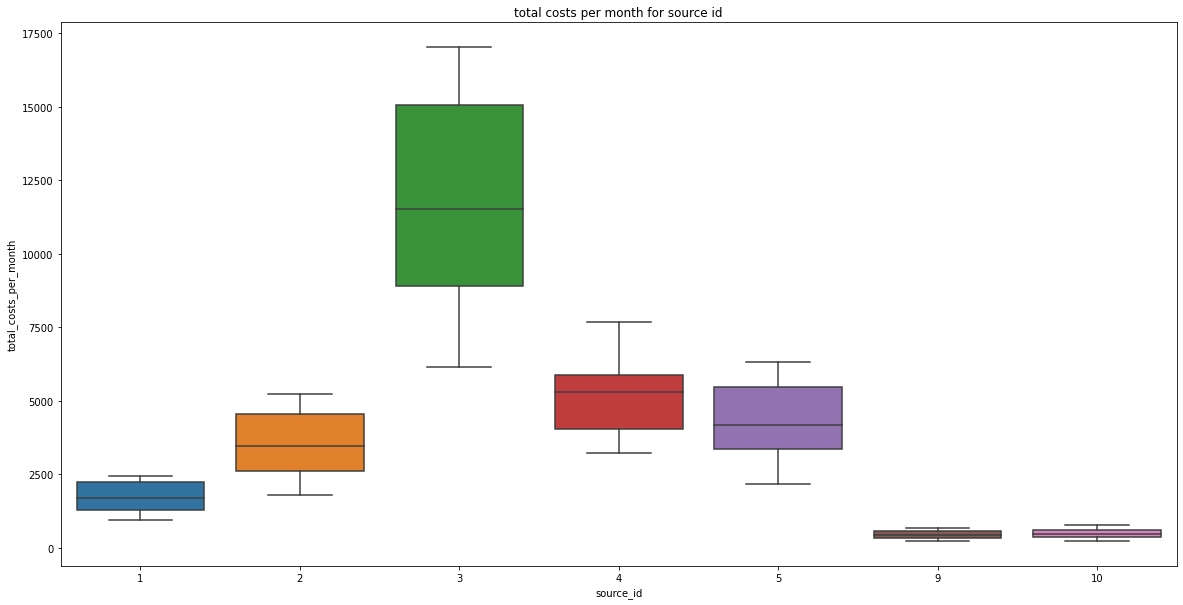

In [71]:
plt.figure(figsize=(20,10))
sns.boxplot(data=total_costs, x='source_id', y='total_costs_per_month')
plt.title('total costs per month for source id')

Kita memiliki 7 sumber iklan. Total biaya yang dikeluarkan per bulan untuk sumber iklan nomor 3 adalah yang tertinggi. Untuk sumber iklan nomor 9 dan 10 jumlah biayanya paling sedikit. Hal ini mungkin saja karena tidak banyak order yang datang dari kedua sumber iklan tersebut.

In [72]:
df_visits = visits.merge(first)
df_visits

,device,end_ts,source_id,start_ts,uid,buy_ts,first_order_ts,first_order_month,order_month
0,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-04 12:46:00,0,2017-09-04,2017-09-01
1,desktop,2017-10-23 12:58:00,3,2017-10-23 12:49:00,4499746016005494365,2017-11-16 14:04:00,24,2017-11-16,2017-11-01
2,desktop,2018-02-25 23:43:00,5,2018-02-25 23:35:00,9344114199116964256,2018-02-25 23:36:00,0,2018-02-25,2018-02-01
3,desktop,2018-01-30 16:30:00,3,2018-01-30 16:04:00,15667207291200562748,2018-01-30 21:16:00,0,2018-01-30,2018-01-01
4,desktop,2017-10-14 18:15:00,5,2017-10-14 18:05:00,9781067627250906649,2017-10-15 14:50:00,0,2017-10-15,2017-10-01
...,...,...,...,...,...,...,...,...,...
36518,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29 19:07:00,0,2017-07-29,2017-07-01
36519,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25 17:38:00,0,2018-01-25,2018-01-01
36520,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03 10:12:00,0,2018-03-03,2018-03-01
36521,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02 10:12:00,0,2017-11-02,2017-11-01


In [73]:
# mendapatkan jumlah users per source id
user_per_source = df_visits.groupby(['source_id','order_month']).agg({'uid': 'count'}).reset_index()
user_per_source.columns = ['source_id','order_month','n_users']
user_per_source

,source_id,order_month,n_users
0,1,2017-06-01,190
1,1,2017-07-01,160
2,1,2017-08-01,113
3,1,2017-09-01,227
4,1,2017-10-01,340
...,...,...,...
81,10,2018-01-01,92
82,10,2018-02-01,123
83,10,2018-03-01,186
84,10,2018-04-01,107


In [74]:
# supaya nama kolom penggabungan sama
total_costs['month'] = total_costs['costs_month']

# perlu memperbaiki tipe data menjadi period[M]
user_per_source['month'] = pd.to_datetime(user_per_source['order_month']).dt.to_period('M')

# perlu memperbaiki tipe data menjadi period[M]
revenue_per_month['month'] = revenue_per_month['buy_month'].dt.to_period('M')

# lakukan penggabungan dengan parameter `on`
data = total_costs.merge(revenue_per_month, on=['month', 'source_id']).merge(user_per_source,on=['month', 'source_id'])

In [75]:
df_ = data.merge(df, on=['order_month','buy_month','source_id'])
df_

,costs_month,source_id,total_costs_per_month,month,buy_month,buy_ts_x,revenue_per_month,order_month,n_users,buy_ts_y,...,device,end_ts,start_ts,session_year,session_month,session_week,session_date,session_duration_sec,first_order_ts,first_order_month
0,2017-06,1,1125.61,2017-06,2017-06-01,190,886.59,2017-06-01,190,2017-06-01 00:10:00,...,desktop,2017-06-01 00:11:00,2017-06-01 00:09:00,2017,6,22,2017-06-01,2.000000,0,2017-06-01
1,2017-06,1,1125.61,2017-06,2017-06-01,190,886.59,2017-06-01,190,2017-06-01 09:22:00,...,desktop,2017-06-01 09:22:19,2017-06-01 09:22:00,2017,6,22,2017-06-01,0.316667,0,2017-06-01
2,2017-06,1,1125.61,2017-06,2017-06-01,190,886.59,2017-06-01,190,2017-06-01 09:23:00,...,desktop,2017-06-01 09:24:00,2017-06-01 09:21:00,2017,6,22,2017-06-01,3.000000,0,2017-06-01
3,2017-06,1,1125.61,2017-06,2017-06-01,190,886.59,2017-06-01,190,2017-06-01 10:38:00,...,desktop,2017-06-01 10:39:00,2017-06-01 10:36:00,2017,6,22,2017-06-01,3.000000,0,2017-06-01
4,2017-06,1,1125.61,2017-06,2017-06-01,190,886.59,2017-06-01,190,2017-06-01 11:01:00,...,desktop,2017-06-01 11:01:00,2017-06-01 11:00:00,2017,6,22,2017-06-01,1.000000,0,2017-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36516,2018-05,10,409.86,2018-05,2018-05-01,130,426.17,2018-05-01,130,2018-05-31 21:14:00,...,desktop,2018-05-31 18:10:00,2018-05-31 17:41:00,2018,5,22,2018-05-31,29.000000,0,2018-05-31
36517,2018-05,10,409.86,2018-05,2018-05-01,130,426.17,2018-05-01,130,2018-05-31 22:50:00,...,desktop,2018-05-31 22:51:00,2018-05-31 22:47:00,2018,5,22,2018-05-31,4.000000,0,2018-05-31
36518,2018-05,10,409.86,2018-05,2018-05-01,130,426.17,2018-05-01,130,2018-05-31 23:01:00,...,desktop,2018-05-31 13:46:00,2018-05-31 13:40:00,2018,5,22,2018-05-31,6.000000,0,2018-05-31
36519,2018-05,10,409.86,2018-05,2018-05-01,130,426.17,2018-05-01,130,2018-05-31 23:40:00,...,desktop,2018-05-31 23:44:00,2018-05-31 23:35:00,2018,5,22,2018-05-31,9.000000,0,2018-05-31


In [76]:
df_['cac'] = df_['total_costs_per_month'] / df_['n_users']
df_['cac']

0        5.924263
1        5.924263
2        5.924263
3        5.924263
4        5.924263
           ...   
36516    3.152769
36517    3.152769
36518    3.152769
36519    3.152769
36520    3.152769
Name: cac, Length: 36521, dtype: float64

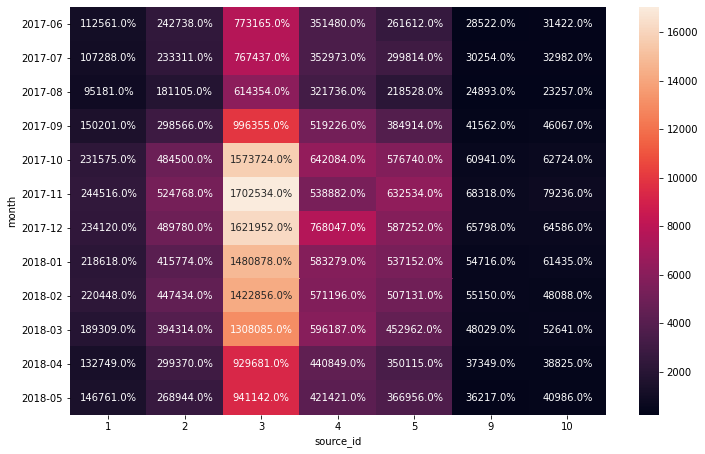

In [77]:
# membuat pivot table cac
cac_pivot = df_.pivot_table(
    index='month',
    columns='source_id',
    values='cac',
    aggfunc='sum')

# menampilkan pivot table dengan heatmap
plt.figure(figsize=(12, 7.5))
sns.heatmap(cac_pivot, fmt='.1%', annot=True)
plt.show()

In [78]:
# mendapatkan jumlah users per source id
user_per_source = df_visits.groupby(['device','order_month']).agg({'uid': 'count'}).reset_index()
user_per_source.columns = ['device','order_month','n_users']
user_per_source

,device,order_month,n_users
0,desktop,2017-06-01,1702
1,desktop,2017-07-01,1526
2,desktop,2017-08-01,1114
3,desktop,2017-09-01,2059
4,desktop,2017-10-01,3532
5,desktop,2017-11-01,3326
6,desktop,2017-12-01,3497
7,desktop,2018-01-01,2674
8,desktop,2018-02-01,2807
9,desktop,2018-03-01,2777


#### Laba Kotor
Selanjutnya kita akan menghitung berapa laba kotor yang dihasilkan. Pertama-tama, mari kita lihat jumlah revenue (LTV) per tahun dan menguranginya dengan jumlah pengeluaran.

In [79]:
# menghitung jumlah revenue per tahun
df['order_year'] = df['order_month'].dt.year
revenue_per_year = df.groupby(['order_year','source_id'])['revenue'].sum().round(2).reset_index()
revenue_per_year.columns = ['order_year','source_id','revenue_per_year']
revenue_per_year

,order_year,source_id,revenue_per_year
0,2017,1,7667.27
1,2017,2,10414.27
2,2017,3,24919.94
3,2017,4,22935.80
4,2017,5,18682.04
5,2017,7,1.22
6,2017,9,2368.09
7,2017,10,1976.81
8,2018,1,5311.74
9,2018,2,7410.11


In [80]:
# menghitung laba kotor
df_['gp'] = df_['revenue_per_month'] - df_['total_costs_per_month']
df_['gp']

0       -239.02
1       -239.02
2       -239.02
3       -239.02
4       -239.02
          ...  
36516     16.31
36517     16.31
36518     16.31
36519     16.31
36520     16.31
Name: gp, Length: 36521, dtype: float64

<AxesSubplot:title={'center':'gross profit'}, xlabel='month'>

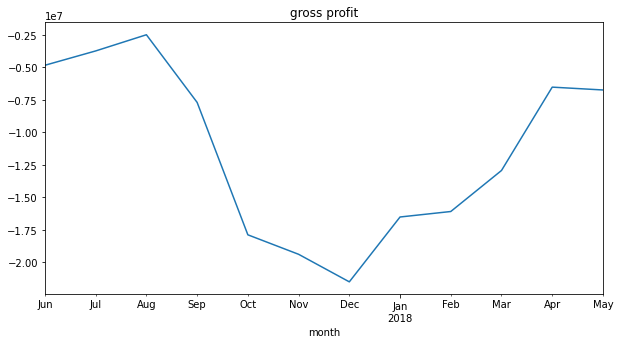

In [81]:
# menampilkan visualisasi gross profit
df_.groupby('month')['gp'].sum().plot(figsize=(10,5), title='gross profit')

Karena kita tidak memiliki data pengeluaran selain sumber iklan, maka kita hanya dapat menghitung laba kotor/gross profit saja. Dari hasil laba kotor, terlihat bahwa kita mendapatkan cukup banyak kerugian. 

#### Return On Investment (ROI)

In [82]:
df_['roi'] = df_['revenue_per_month'] / df_['total_costs_per_month']
df_['roi']

0        0.787653
1        0.787653
2        0.787653
3        0.787653
4        0.787653
           ...   
36516    1.039794
36517    1.039794
36518    1.039794
36519    1.039794
36520    1.039794
Name: roi, Length: 36521, dtype: float64

In [83]:
roi_pivot = df_.pivot_table(index='costs_month',columns='source_id',values='roi',aggfunc='sum')
roi_pivot

source_id,1,2,3,4,5,9,10
costs_month,,,,,,,
2017-06,149.654054,74.766126,212.620732,204.592924,244.624375,51.368347,60.944879
2017-07,135.030945,124.473171,176.071740,379.299040,278.510907,34.564686,21.513644
2017-08,74.520093,38.401971,87.613396,158.376831,275.466027,48.404491,26.966075
2017-09,160.111011,82.008775,293.458876,272.373860,423.290288,66.636784,32.641804
2017-10,220.667084,162.699195,342.555376,804.940020,712.444863,115.651794,167.225990
2017-11,193.162918,140.703248,343.341546,1107.249118,313.514973,98.138924,80.776213
2017-12,173.528998,212.106180,395.957781,936.069629,445.513727,76.116463,38.146425
2018-01,117.459550,75.759004,257.155055,637.953953,280.169954,28.649755,41.279075
2018-02,134.005865,87.017138,289.304911,806.138684,347.315053,52.894869,75.342871


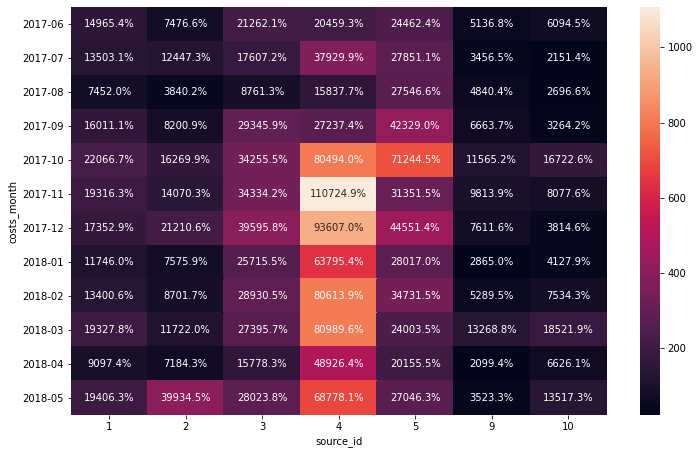

In [84]:
# menampilkan pivot table dengan heatmap
plt.figure(figsize=(12, 7.5))
sns.heatmap(roi_pivot, fmt='.1%', annot=True)
plt.show()

**Kesimpulan Data Marketing:**
Pengeluaran untuk setiap sumber iklan telah berhasil kita hitung, nominalnya tertinggi adalah untuk sumber iklan nomor 3 yaitu sekitar 142.000, sementara untuk biaya terkecil sumber iklan yang kita keluarkan adalah untuk nomor 9 dan 10 

### Membuat Grafik

Berikutnya kita akan membuat grafik berdasarkan source_id untuk melihat penjualan terbanyak berasal dari sumber iklan yang mana.

In [85]:
df_['roi']

0        0.787653
1        0.787653
2        0.787653
3        0.787653
4        0.787653
           ...   
36516    1.039794
36517    1.039794
36518    1.039794
36519    1.039794
36520    1.039794
Name: roi, Length: 36521, dtype: float64

Text(0.5, 1.0, 'total sales based on source_id')

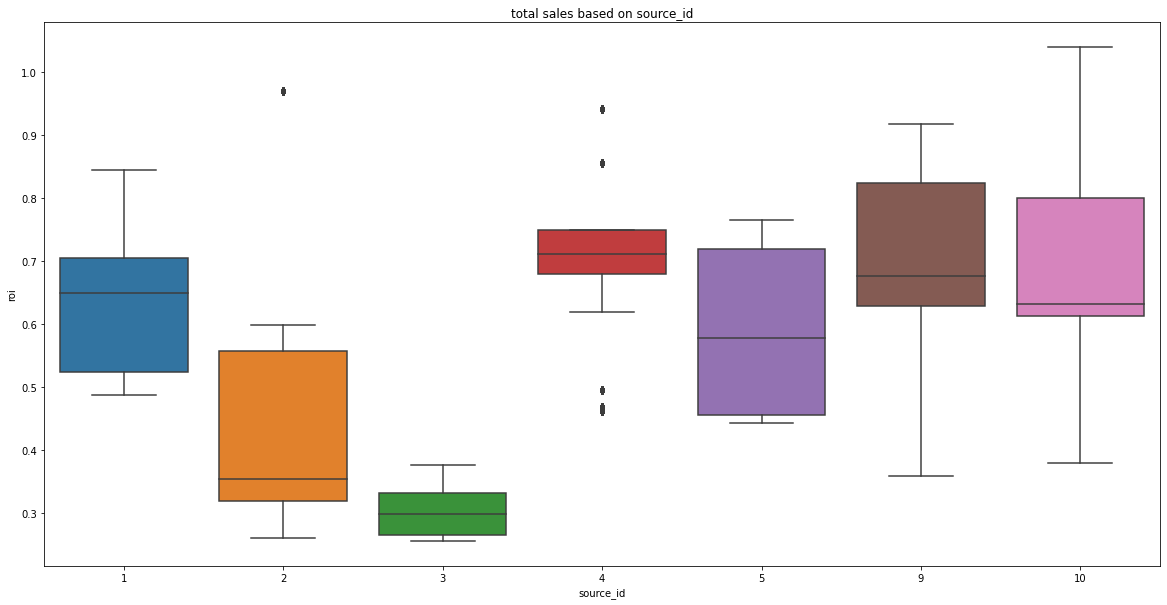

In [86]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df_, x='source_id', y='roi')
plt.title('total sales based on source_id')

Ternyata sumber iklan yang memberikan banyak penjualan adalah nomor 2 dan 5. Sumber iklan yang paling sedikit memberikan orderan adalah nomor 3 dan 4. Dari 7 sumber iklan, kita memiliki 5 sumber iklan yang cukup banyak memberikan orderan.

In [87]:
# gabungkan dataframe visit dengan order untuk menyatukan kolom device dan revenue
device_df = visits.merge(orders, on='uid')

# pastikan ambil hanya order yang berada pada durasi sesi visit
device_df = device_df[device_df['buy_ts'].between(device_df['start_ts'], device_df['end_ts'])]

# hitung statistik masing-masing device
device_df = device_df.groupby('device').agg({'uid': 'nunique', 'revenue': 'sum'}).reset_index()
device_df['revenue_per_user'] = device_df['revenue'] / device_df['uid']
device_df

,device,uid,revenue,revenue_per_user
0,desktop,24720,143831.82,5.818439
1,touch,5300,23314.11,4.398889


Dari hasil perhitungan diatas, dapat dilihat bahwa pengguna lebih banyak menggunakan perangkat desktop untuk melakukan order. Selisihnya dapat dibilang cukup jauh, lebih dari 50%. Mungkin versi situs atau aplikasi desktop lebih mudah dan nyaman digunakan.

Text(0.5, 1.0, 'total sales based on device')

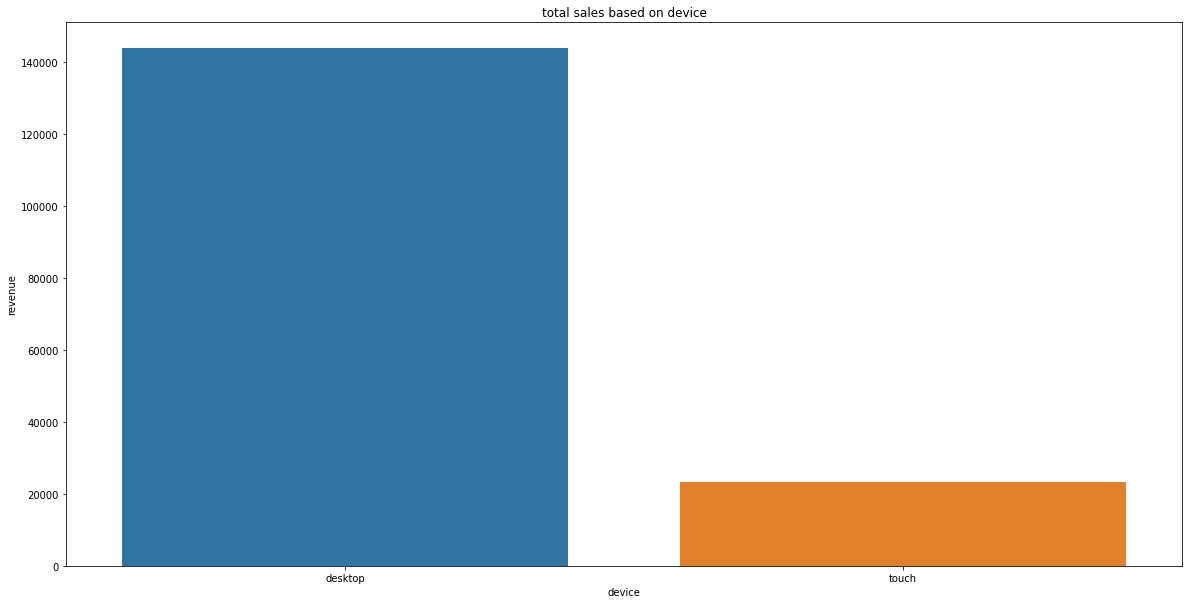

In [88]:
plt.figure(figsize=(20,10))
sns.barplot(data=device_df, x='device', y='revenue')
plt.title('total sales based on device')

## Tahap 3 Kesimpulan

Setelah melalui proses cukup panjang untuk menganalisa data, berikut kesimpulan yang di dapat :
1. Kunjungan pengguna per sesi dalam waktu sebulan naik turun cenderung stabil, rasio pengguna yang kembali menggunakan produk adalah sekitar 4%.
2. Rata-rata pengguna melakukan order sekitar 16 hari setelah kunjungan, namun banyak juga pengguna yang langsung melakuka order saat pertama kali berkunjung.
3. Jumlah revenue per bulan cukup bagus, tetapi nominal terendah ada pada bulan Juni 2016 dengan nominal 3.42 saja
4. Mungkin perusahaan dapat **lebih fokus untuk biaya sumber iklan yang banyak mendatangkan jumlah orderan yang lebih banyak (iklan nomor 1,2,5,9 dan 10)** dan menghentikan penggunaan sumber iklan yang lainnya.
5. Jumlah pengguna yang melakukan order lebih banyak menggunakan desktop, mungkin karena versi desktop lebih mudah dan nyaman untuk digunakan. Versi touch mungkin dapat diperbarui agar pengguna touch juga lebih nyaman melakukan order.